# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
load_module = True

if load_module:
    module_name = "edlif_psc_alpha_0_module"
    nest.Install(module_name)
    neuron_model = ["edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml.nestml"]
    neuron_id = 0
else:
    neuron_model = [
        "edlif_psc_base.nestml", 
        "edlif_psc_nonlineardendrite.nestml",
        "edlif_psc_supply_state.nestml",
        "edlif_psc_supply_inline.nestml",
        "edlif_psc_percent.nestml",
        "../network/models/neurons/edlif_psc_alpha_percent.nestml"
    ]
    neuron_id = 5
    generate_nest_target(input_path=neuron_model[neuron_id],
                         target_path="/tmp/nestml-component",
                         logging_level="INFO",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})
    
    nest.Install("nestmlmodule")


Oct 08 21:55:33 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


resolution time: 0.1
Using neuron model: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml
Using  current generator
spikes times: 107
firing rate: 107.0


/tmp/ipykernel_21873/2188561446.py:93: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


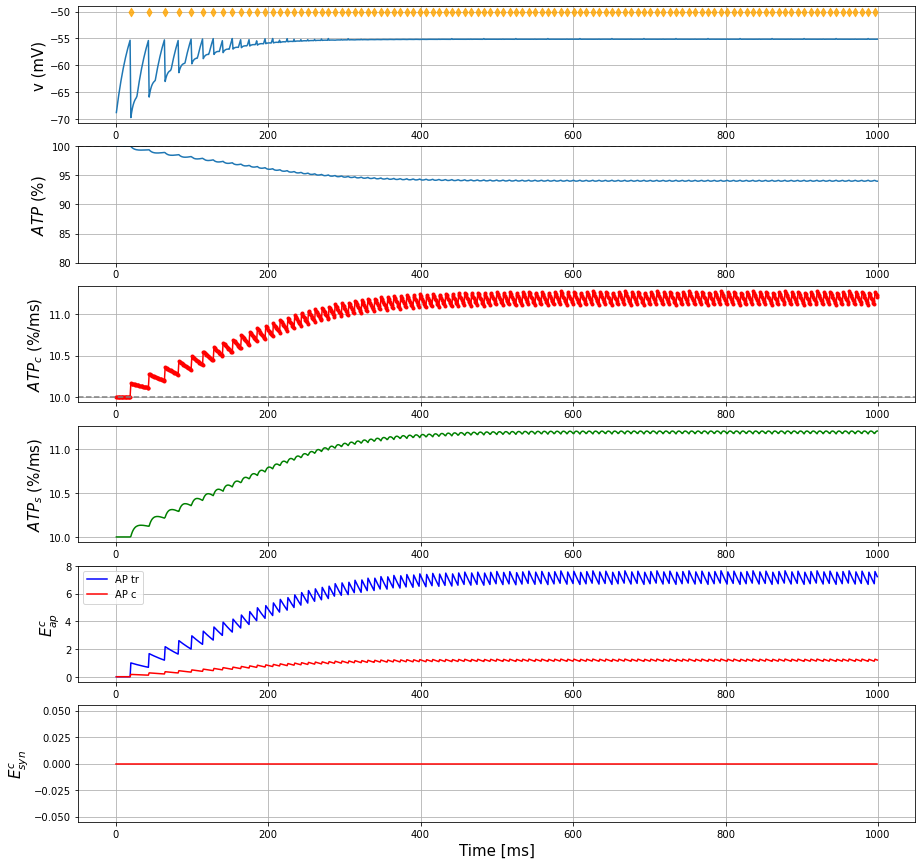

In [16]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

# resolution
nest.resolution = 0.1
resolution = nest.GetKernelStatus()["resolution"]
print(f"resolution time: {resolution}") 

neuron_model_name = neuron_model[neuron_id].split("/")[-1].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

# current generator
gen = "" # dc o ac
print(f"Using {gen} current generator")

neuron = nest.Create(neuron_model_name)
voltmeter = nest.Create("voltmeter")

# change neuron params

if gen == "":
    neuron.I_e = 299
neuron.tau_m = 20 #20
neuron.tau_syn_ex = 6
neuron.tau_syn_in = 6
neuron.C_m = 250 #250
neuron.t_ref = 8 #2
# energy params
neuron.K_ATP = 0.2
neuron.gamma = 90
neuron.tau_ap = 60
neuron.E_ap = 10
neuron.E_rp = 5
neuron.E_hk = 5
neuron.E_syn_ex = neuron.E_ap/2
neuron.E_syn_in = neuron.E_ap/2
neuron.tau_syn_atp_ex = 100
neuron.tau_syn_atp_ex = 100

voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter, neuron)

if gen == "dc":
    cgs = nest.Create('dc_generator')
    cgs.set({"amplitude": 375.86})
elif gen == "ac":
    cgs = nest.Create('ac_generator')
    cgs.set({"amplitude": 100})
    cgs.set({"offset": 180})
    cgs.set({"frequency": 3})
if gen != "":    
    nest.Connect(cgs, neuron)

sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)

simtime = 1000.*1
nest.Simulate(simtime)

# precision
#error = nest.GetStatus(neuron, "gsl_error_tol")
#print(f"absolute error of integration: {error}")

spike_times = nest.GetStatus(sr, keys='events')[0]['times']

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))
ax[0].plot(voltmeter.get("events")["times"], voltmeter.get("events")["V_m"])
ax[1].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP"])
ax[1].axhline(y=neuron.get("ATP_h"), c="gray", ls="--")
ax[1].set_ylim(80., 100.01)
ax[2].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_c"], c="r", marker ='.')
ax[2].axhline(y=neuron.get("ATP_basal"), c="gray", ls="--")
ax[3].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_s"], c="g")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr"], c="b", label="AP tr")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_c"], c="r", label="AP c")
#ax[4].set_ylim(0, 0.05)
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr2"], c="b")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_der"], c="r")
ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_syn_c"], c="r")
ax[0].scatter(spike_times, -50 * np.ones_like(spike_times), marker="d", c="orange", alpha=.8, zorder=99)
for _ax in ax:
    _ax.grid(True)
ax[0].set_ylabel("v (mV)", fontsize=fontsize)
ax[1].set_ylabel("$ATP$ (%)", fontsize=fontsize)
ax[2].set_ylabel("$ATP_c$ (%/ms)", fontsize=fontsize)
ax[3].set_ylabel("$ATP_s$ (%/ms)", fontsize=fontsize)
ax[4].set_ylabel("$E_{ap}^{tr}$", fontsize=fontsize)
ax[4].set_ylabel("$E_{ap}^{c}$", fontsize=fontsize)
ax[5].set_ylabel("$E_{syn}^{c}$", fontsize=fontsize)
ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
ax[4].legend()
fig.show()

print(f'spikes times: {len(spike_times)}')
print(f'firing rate: {len(spike_times)/simtime * 1000}')

In [4]:
#nest.kernel_status